In [1]:
import pandas as pd
import os
import numpy as np
from get_data import read_synapse_file
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE,RFECV,SelectKBest
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from feature_selection import data_preprocessing
from rfpimp import importances
%load_ext autoreload
%autoreload 2

In [2]:
path = 'd:/data/MCF10A 090718 data/'
os.chdir(path)
feature_files = [x for x in os.listdir() if '_txt' in x]
pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)
print(feature_files)

Welcome, Yunguan Wang!

['plate_6_txt_features_all.hdf', 'plate_6_txt_features_BMP2.hdf', 'plate_6_txt_features_EGF.hdf', 'plate_6_txt_features_HGF.hdf', 'plate_6_txt_features_IFNG.hdf', 'plate_6_txt_features_OSM.hdf', 'plate_6_txt_features_PBS.hdf', 'plate_6_txt_features_TGFB.hdf']


# Getting some simple stats on data, e.g., std, cv
## Since Anova is fast, ran it on all data instead of sampled data

# Read and bin the data well-wise
### Note: Scaling for PCA

In [3]:
x_binned = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand)
    cm_cells = [k for k in _x.index if k in pooled_metadata.index]
    _x = _x.loc[cm_cells].groupby(pooled_metadata.loc[cm_cells,'Well']).median()
    if x_binned.shape[0]==0:
        x_binned = _x
    else:
        cols = [k for k in x_binned.columns if k in _x.columns]
        _x = _x[cols]
        x_binned = x_binned[cols].append(_x[cols])
    y += [ligand]*_x.shape[0]
# scaling
y_binned = y
x_scale = x_binned.copy()
x_scale.loc[:,:] = minmax_scale(x_scale)

## Read full data just for anova

In [4]:
x = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand)
    if x.shape[0]==0:
        x = _x
    else:
        cols = [k for k in x.columns if k in _x.columns]
        x = x[cols].append(_x[cols])
    y+=_y
x.loc[:,:] = minmax_scale(x)

## Figure 1A std histogram and 1B ANOVA

Text(0.5, 1.0, 'ANOVA F scores across all samples')

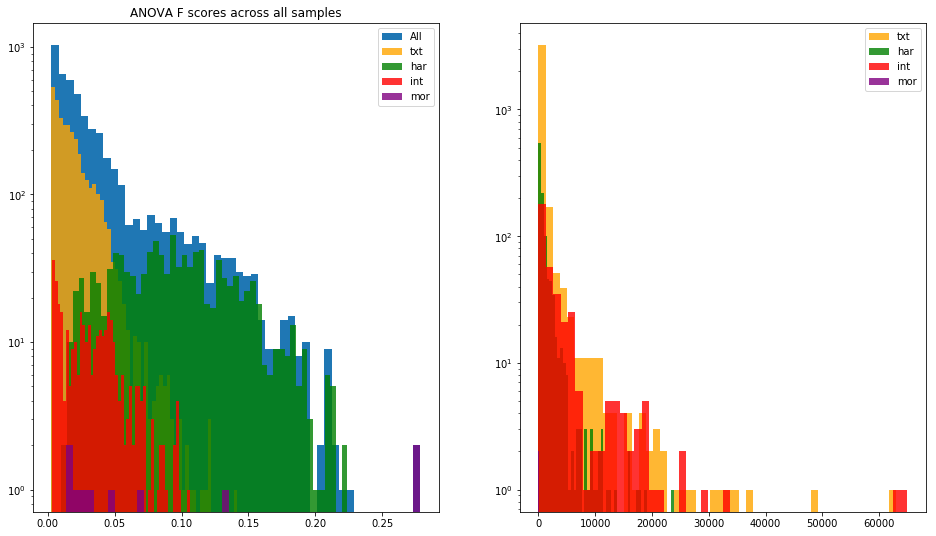

In [8]:
# Anova
sk = SelectKBest(k=x.shape[1])
sk.fit(x,y)
sk_fs = sk.get_support()
sk_fs = x.columns[sk_fs]

all_features = x.columns
_, axes = plt.subplots(ncols=2, figsize=(16,9))
axes = axes.ravel()
axes[0].hist(x.std(),bins=50, label='All')
for feature_type,c in zip(['_txt_','_har_','_int_','mor'],['orange','g','red','purple']):
    feature_list = [k for k in all_features if feature_type in k]
    axes[0].hist(x[feature_list].std(), bins=50, label=feature_type.replace('_',''),alpha=0.8,color=c)
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_title('Distribution of std across all samples')

anova = pd.Series(sk.scores_, index=x.columns)
for feature_type,c in zip(['_txt_','_har_','_int_','mor'],['orange','g','red','purple']):
    feature_list = [k for k in all_features if feature_type in k]
    axes[1].hist(anova[feature_list], bins=50,label=feature_type.replace('_',''),alpha=0.8,color=c)
axes[1].legend()
# axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].set_title('ANOVA F scores across all samples')

# PCA to test if the centroids are separable

array([0.36026834, 0.25624167])

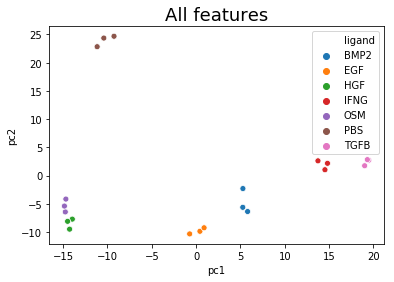

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca=PCA(2)
pca_x = pca.fit_transform(x_scale)
pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
pca_x['ligand'] = y_binned
sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand')
plt.title('All features', fontsize=18)
pca.explained_variance_ratio_

# Repeat the previous analysis using each feature category
### Figure 2

Number of _txt_ features : 3596
Number of _har_ features : 1080
Number of _int_ features : 360
Number of mor features : 10
Total number of these categories: 5046 out of total of 5046


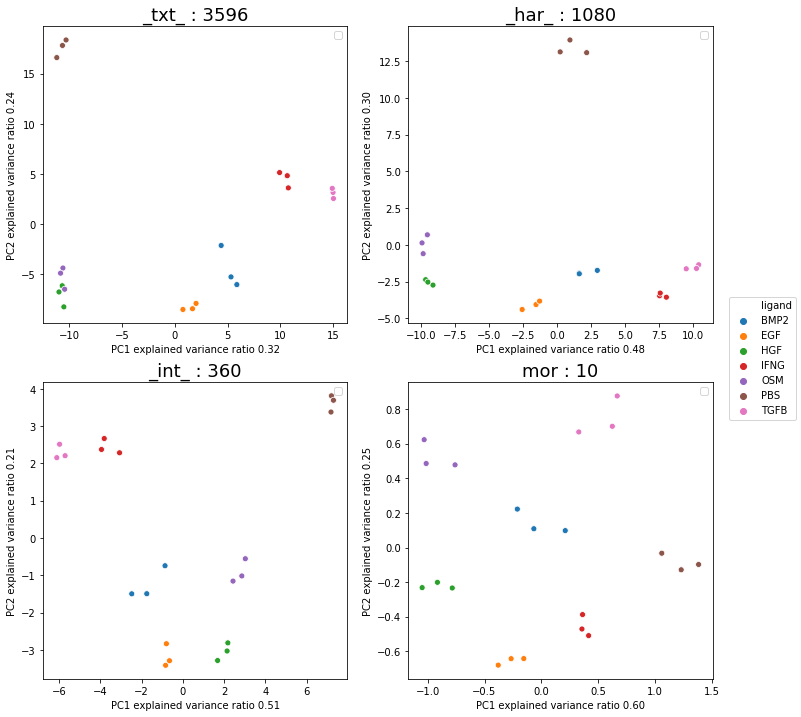

In [10]:
# Get feature stats
all_featuers  = x_scale.columns
txt_features = [k for k in all_featuers if '_txt_' in k]
har_features = [k for k in all_featuers if '_har_' in k]
int_features = [k for k in all_featuers if '_int_' in k]
mor_features = [k for k in all_featuers if 'mor' in k]
sum_features=0
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    num_features = len(feature_list)
    print('Number of {} features : {}'.format(feature_type, num_features))
    sum_features+=num_features
print('Total number of these categories: {} out of total of {}'.format(sum_features, len(all_featuers)))

# PCA plots of each feature category
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.ravel()
i=0
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    num_features = len(feature_list)
    pca=PCA(2)
    pca_x = pca.fit_transform(x_scale[feature_list])
    pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
    pca_x['ligand'] = sorted(y_binned)
    g = sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand', ax = axes[i])
    if i==0:
        lgd_handles, lgd_labels = g.get_legend_handles_labels()
    g.set_title('{} : {}'.format(feature_type,num_features), fontsize=18)
    g.legend('')
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    g.set_xlabel('PC1 explained variance ratio {:.2f}'.format(pc1))
    g.set_ylabel('PC2 explained variance ratio {:.2f}'.format(pc2))
    i+=1
fig.legend(lgd_handles, lgd_labels,loc='center right')

# Feature selection based on sampling and emsembling

In [11]:
x = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    print('Processing {}'.format(ligand))
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand, sample_size=1500)
    if x.shape[0]==0:
        x = _x
    else:
        cols = [k for k in x.columns if k in _x.columns]
        x = x[cols].append(_x[cols])
    y+=_y
x.loc[:,:] = minmax_scale(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

Processing BMP2
Processing EGF
Processing HGF
Processing IFNG
Processing OSM
Processing PBS
Processing TGFB


## Evaluate full model and models with different cat of features

In [12]:
print(x_train.shape)
full_model = RandomForestClassifier(100)
full_model.fit(x_train, y_train)
y_pred = full_model.predict(x_test)
print('Full feature accuracy {}'.format(acc(y_test, y_pred)))

(8400, 5046)
Full feature accuracy 0.950952380952381


In [33]:
cat_model = RandomForestClassifier(100)
model_stats = pd.DataFrame()
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    rf_cv = cross_val_score(cat_model, x_train[feature_list], y_train,scoring='accuracy', cv=10,n_jobs=4)
    model_stats.loc['mean',feature_type] = rf_cv.mean()
    model_stats.loc['sd',feature_type] = rf_cv.std()
    print('CV accurary with feature category {}: {:.2f}'.format(feature_type, rf_cv.mean()))

CV accurary with feature category _txt_: 0.95
CV accurary with feature category _har_: 0.82
CV accurary with feature category _int_: 0.94
CV accurary with feature category mor: 0.24


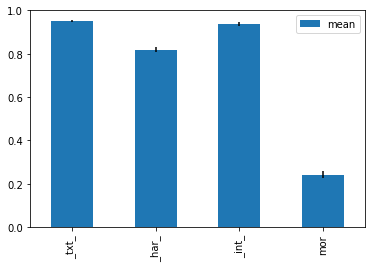

In [39]:
model_stats.transpose().plot(kind='bar',yerr='sd')

## It is now very clear the morphology features performs terribly on their own.
### Why they looked so good on PCA plot? 
### Remember the assumption before doing binning based PCA, which is high hemogeneity in data.

### Evaluate the single cell level data on morphology feature. (10% sampled data)

Text(0.5, 1.0, '10 morphology feature')

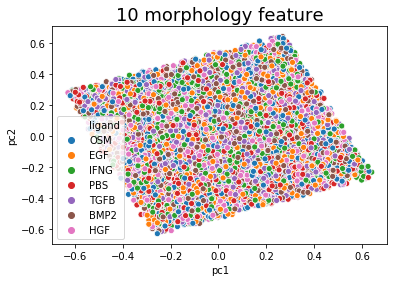

In [16]:
pca=PCA(2)
pca_x = pca.fit_transform(x_train[feature_list])
pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
pca_x['ligand'] = y_train
sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand')
plt.title('10 morphology feature', fontsize=18)

## Get feature importance based on Anova in training set

In [ ]:
num_features = 50
# Anova
sk = SelectKBest(k=num_features)
sk.fit(x_train,y_train)
sk_fs = sk.get_support()
sk_fs = x.columns[sk_fs].tolist()

## Get feature importance and top features on classical RF

In [20]:
print(x_train.shape)
full_model = RandomForestClassifier(100)
full_model.fit(x_train, y_train)
y_pred = full_model.predict(x_test)
print('Full feature accuracy {}'.format(acc(y_test, y_pred)))

(8400, 5046)
Full feature accuracy 0.9514285714285714


In [21]:
fi_full = pd.Series(full_model.feature_importances_, index=x.columns)
rf_fs = fi_full.sort_values(ascending=False).index[:num_features].tolist()

# Get feature importance and top features based on cross-validated RF feature importance

In [22]:
rfcv_x_train, rfcv_x_test, rfcv_y_train, rfcv_y_test = train_test_split(x_train,y_train, test_size=0.20)
rfcv = RandomForestClassifier(100, n_jobs=4)
rfcv.fit(rfcv_x_train,rfcv_y_train)
rfcv_y_pred = rfcv.predict(rfcv_x_test)
print('Full feature accuracy {}'.format(acc(rfcv_y_test, rfcv_y_pred)))
fs_imp = importances(rfcv, rfcv_x_test, pd.Series(rfcv_y_test)) # permutation
rfpimp_fs = fs_imp.index[:num_features].tolist()

Full feature accuracy 0.950595238095238


# Get top 20 features using RFE with random forest for non-linear relationships

In [23]:
rfe_input_features = fi_full.sort_values(ascending=False).index[:500]
sampled_x = x_train[rfe_input_features]
sampled_y = y_train
estimator = RandomForestClassifier(100)
selector = RFE(estimator, n_features_to_select=num_features, step=25, verbose=1)
selector = selector.fit(sampled_x, sampled_y)
rfe_fs_rf = sampled_x.columns[selector.support_]

Fitting estimator with 500 features.
Fitting estimator with 475 features.
Fitting estimator with 450 features.
Fitting estimator with 425 features.
Fitting estimator with 400 features.
Fitting estimator with 375 features.
Fitting estimator with 350 features.
Fitting estimator with 325 features.
Fitting estimator with 300 features.
Fitting estimator with 275 features.
Fitting estimator with 250 features.
Fitting estimator with 225 features.
Fitting estimator with 200 features.
Fitting estimator with 175 features.
Fitting estimator with 150 features.
Fitting estimator with 125 features.
Fitting estimator with 100 features.
Fitting estimator with 75 features.


# Get top 20 features using RFE with logistic regression for linear relationships

In [24]:
rfe_input_features = fi_full.sort_values(ascending=False).index[:500]
sampled_x = x_train[rfe_input_features]
sampled_y = y_train
estimator = LogisticRegression(solver='newton-cg', multi_class='auto')
selector = RFE(estimator, n_features_to_select=num_features, step=25, verbose=1)
selector = selector.fit(sampled_x, sampled_y)
rfe_fs_lr = sampled_x.columns[selector.support_]

Fitting estimator with 500 features.
Fitting estimator with 475 features.
Fitting estimator with 450 features.
Fitting estimator with 425 features.
Fitting estimator with 400 features.
Fitting estimator with 375 features.
Fitting estimator with 350 features.
Fitting estimator with 325 features.
Fitting estimator with 300 features.
Fitting estimator with 275 features.
Fitting estimator with 250 features.
Fitting estimator with 225 features.
Fitting estimator with 200 features.
Fitting estimator with 175 features.
Fitting estimator with 150 features.
Fitting estimator with 125 features.
Fitting estimator with 100 features.
Fitting estimator with 75 features.


## Summerize over all features

In [25]:
all_features = pd.DataFrame(index = x_train.columns)
for col, fs_list in zip(['Anova','RF','RF_cv','RFE_rf','RFE_lr'],[sk_fs, rf_fs, rfpimp_fs, rfe_fs_rf, rfe_fs_lr]):
    all_features.loc[fs_list,col] = 1
all_features.fillna(0,inplace=True)
all_features = all_features.sum(axis=1).sort_values(ascending=False)
all_features = pd.DataFrame(all_features, columns=['feature_rank'])
all_features['RF_cv_fi'] = fs_imp.loc[all_features.index].values
all_features = all_features.sort_values(['feature_rank','RF_cv_fi'], ascending=False)
best_features = all_features.index.tolist()[:num_features]

## Evaluate features on test set

In [31]:
for col, fs_list in zip(['Anova','RF','RF_cv','RFE_rf','RFE_lr','Best', 'Best_20'],[sk_fs, rf_fs, rfpimp_fs, rfe_fs_rf, rfe_fs_lr, best_features, best_features[:20]]):
    sub_features = fs_list
    x_train_sub = x_train[sub_features]
    x_test_sub = x_test[sub_features]
    fs_model = RandomForestClassifier(100)
    fs_model.fit(x_train_sub, y_train)
    y_pred = fs_model.predict(x_test_sub)
    print('{}: Selected feature accuracy {:.2f}'.format(col,acc(y_test, y_pred)))
y_pred = full_model.predict(x_test)
print('Full feature model accuracy {:.2f}'.format(acc(y_test, y_pred)))

Anova: Selected feature accuracy 0.90
RF: Selected feature accuracy 0.95
RF_cv: Selected feature accuracy 0.93
RFE_rf: Selected feature accuracy 0.96
RFE_lr: Selected feature accuracy 0.95
Best: Selected feature accuracy 0.95
Best_20: Selected feature accuracy 0.93
Full feature model accuracy 0.95


In [32]:
best_features[:20]

['egfr_5_af488fitc_txt_standev_plasmem',
 'egfr_5_af488fitc_txt_standev_cyto',
 's6ps235s236_19_af647cy5_txt_standev_nuc',
 'stat3_13_af488fitc_txt_standev_nuc',
 'stat3_13_af488fitc_txt_standev_nucring',
 'egfr_5_af488fitc_int_mean_plasmem',
 'stat1alphaisoform_31_af647cy5_int_mean_nuc',
 's6ps235s236_19_af647cy5_txt_standev_nucring',
 'stat1alphaisoform_31_af647cy5_txt_standev_nuc',
 'stat1alphaisoform_31_af647cy5_int_med_nuc',
 'cjun_33_af488fitc_int_med_nuc',
 's6ps235s236_19_af647cy5_txt_standev_plasmem',
 'stat3_13_af488fitc_txt_laws_ss9_nuc',
 'stat3_13_af488fitc_txt_laws_lr5_nuc',
 'stat3_13_af488fitc_int_mean_nuc',
 's6ps235s236_19_af647cy5_int_med_plasmem',
 'stat1alphaisoform_31_af647cy5_txt_standev_nucring',
 'stat1alphaisoform_31_af647cy5_txt_standev_cyto',
 'cytokeratin18_25_af488fitc_txt_standev_plasmem',
 'cytokeratin18_25_af488fitc_txt_standev_nuc']

## Permutation based estimate on feature set significance

In [40]:
i=0
x_train_sub = x_train[best_features]
x_test_sub = x_test[best_features]
fs_model = RandomForestClassifier(100)
fs_model.fit(x_train_sub, y_train)
y_pred = fs_model.predict(x_test_sub)
best_fs_acc = acc(y_test, y_pred)
acc_best_inferior = 0
print('Selected best feature accuracy {:.2f}'.format(acc(y_test, y_pred)))
while i < 100:
    random_features = np.random.choice(x.columns, replace=False, size=num_features)
    test_model = RandomForestClassifier(100)
    fs_model.fit(x_train[random_features], y_train)
    y_pred = fs_model.predict(x_test[random_features])
    random_fs_acc = acc(y_test, y_pred)
    if random_fs_acc>=best_fs_acc:
        print('Randomly selected feature accuracy: {:.2f}'.format(random_fs_acc))
        acc_best_inferior+=1
    i+=1
print('Pval of best feature : {}'.format(acc_best_inferior/100))

Selected best feature accuracy 0.95
Pval of best feature : 0.0
